In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sunspots/Sunspots.csv


# Importing all necessary libraries

In [2]:
#for linear algebra and data manupulation
import numpy as np
import pandas as pd

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for model building
import tensorflow as tf

#ignore warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('../input/sunspots/Sunspots.csv')
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:
data.tail()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8
3264,3264,2021-01-31,10.4


In [5]:
#general info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.6+ KB


* total no. of records  = 3265
* No null values found
* We are all set to extract our sunspots data from this dataframe and visualize it

In [6]:
# Last column --> Sunspots data
sunspots = data.iloc[:, -1]
sunspots.values

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

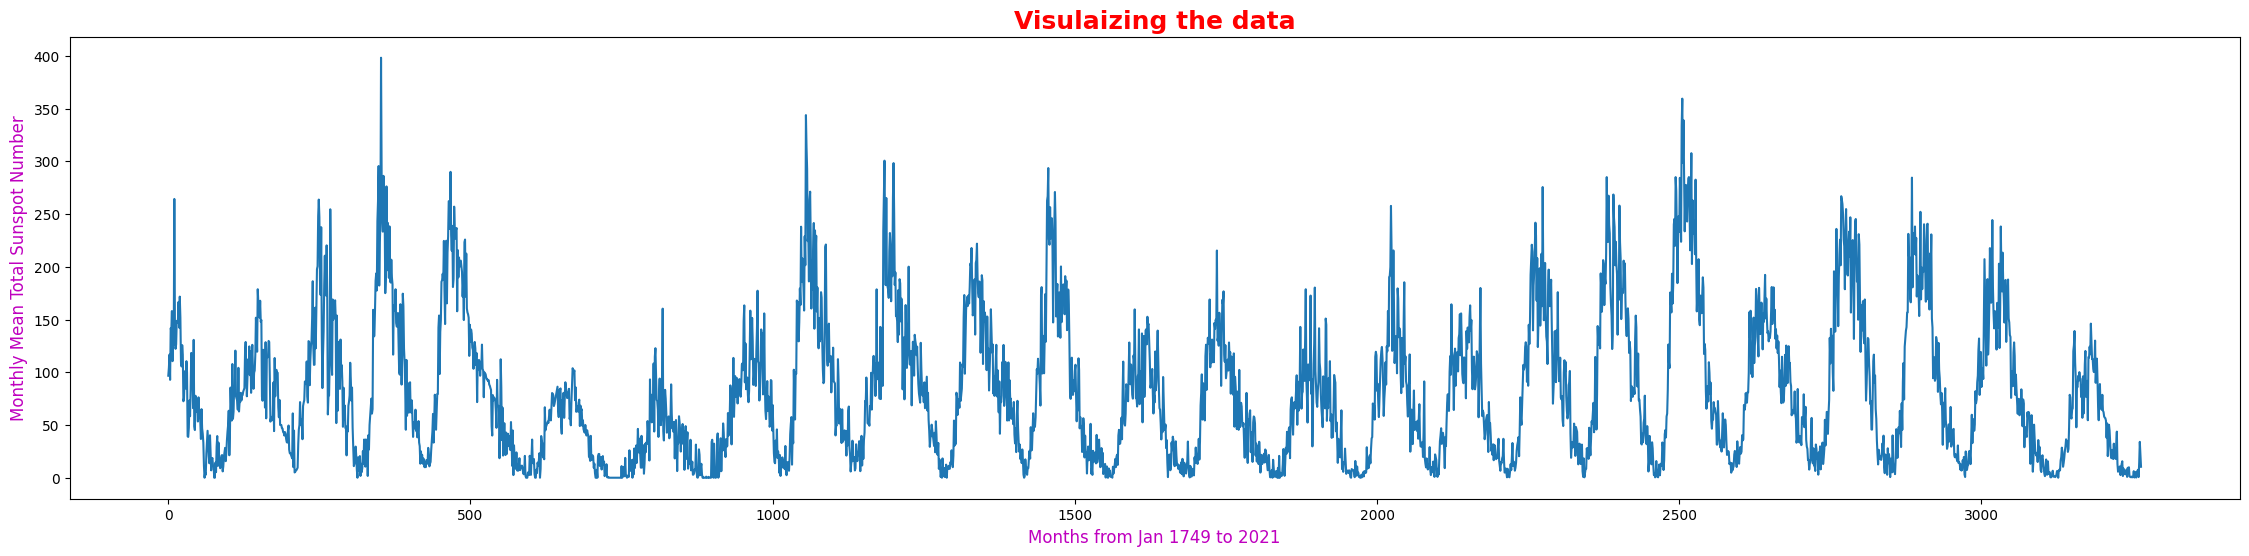

In [7]:
# visulaizing data
plt.figure(figsize=(28,6))
plt.plot(sunspots)
plt.ylabel(data.columns[-1], fontsize=12, color = 'm')
plt.xlabel("Months from Jan 1749 to 2021", fontsize=12,color='m')
plt.title("Visulaizing the data", fontsize=18, color='r', weight = 'bold')
plt.show()

* The first solar cycle started from 1755 but our sunspot data starts from 1749. That's a total of 6 years, which means 72 months of data
* Hence, we can clearly see the initial part of the graph decreasing to minimum till the first 72 months
* Each solar cycle last for 11 years, that is about 132 months
* The current solar cycle is the solar cycle 25 which began in December 2019 but our data is till January 2021. That's about 13 months of data from the current cycle

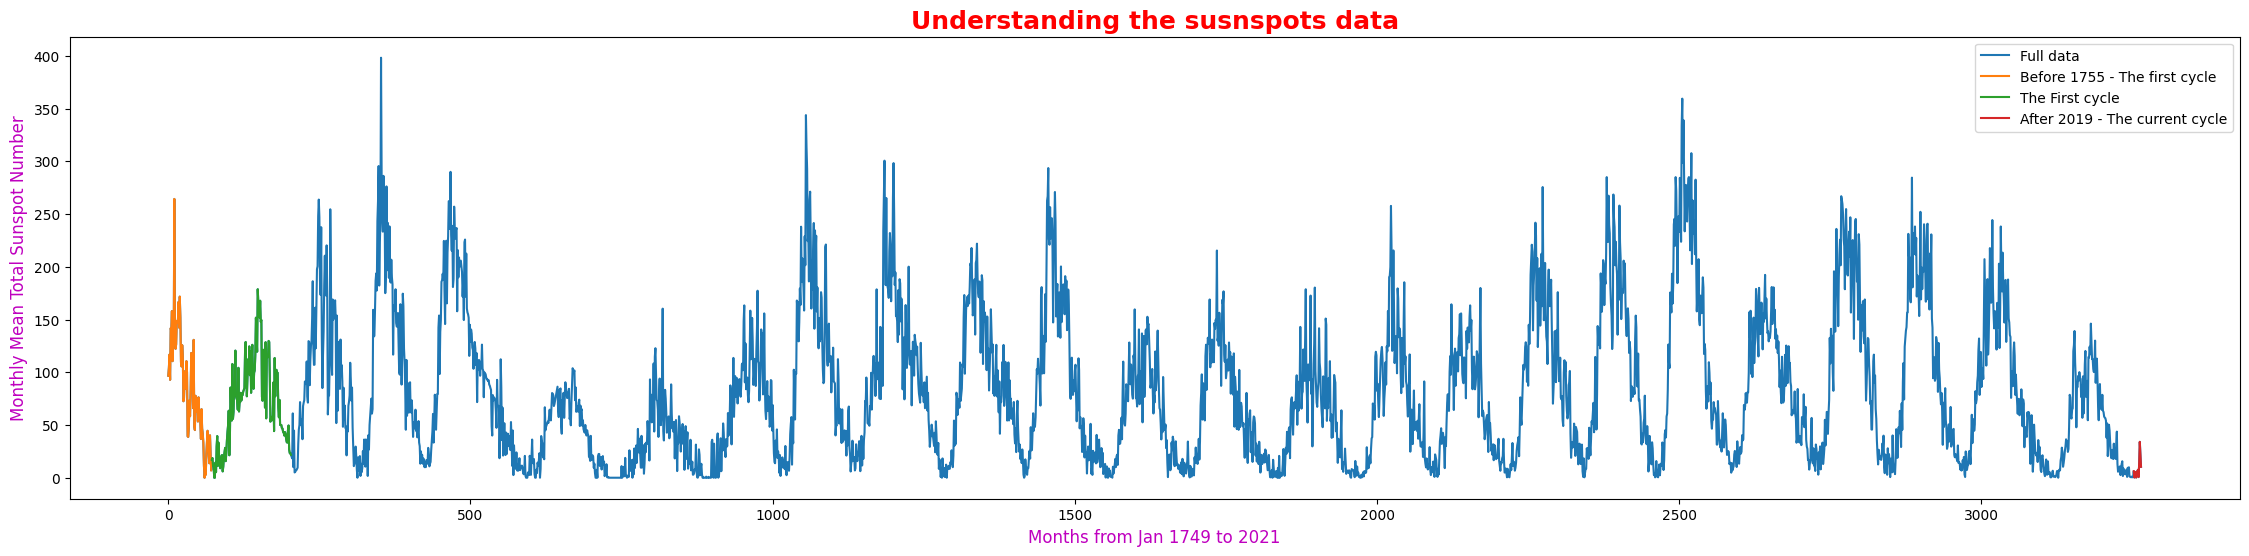

In [8]:
# highlighting the above points in our visulaization
"""Approx !! years of cycle --> approx 132 months cycle"""
plt.figure(figsize=(28,6))
plt.plot(sunspots) #The whole dataset
plt.plot(sunspots[:72]) #Data from 1749, actual cycle starts from 1755 --> 72 months
plt.plot(sunspots[72:72+132]) # Showing the first cycle
plt.plot(sunspots[-13:]) # Displaying the current cycle
plt.ylabel(data.columns[-1], fontsize = 12, color='m')
plt.xlabel("Months from Jan 1749 to 2021", fontsize=12, color='m')
plt.title("Understanding the susnspots data", fontsize = 18, color ='r', weight='bold')
plt.legend(["Full data", "Before 1755 - The first cycle", "The First cycle", 'After 2019 - The current cycle'])
plt.show()

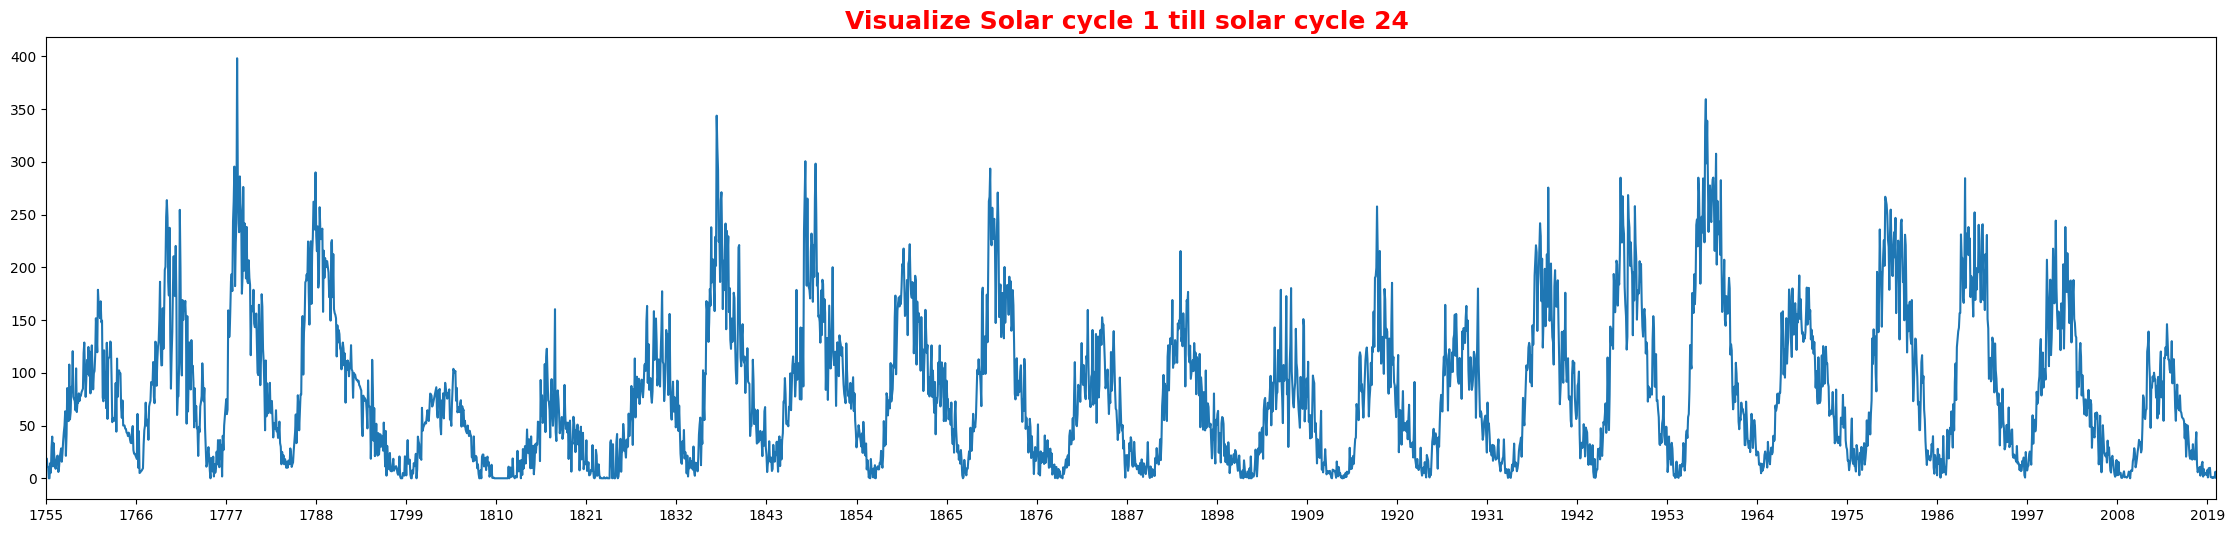

In [9]:
# some changes for a better visualization of solar system
"""Collect all the years from 1755 to 2019 and use it as xtickslabels"""
years=[]
start = 1755
for i in range(0, len(data.iloc[:,-1][72:]),132):
    years.append(start)
    start+=11
    
plt.figure(figsize=(28,6))
plt.plot(sunspots[72:])
plt.title("Visualize Solar cycle 1 till solar cycle 24 ", weight='bold', color='r', fontsize=18)
plt.xlim(72,3265-12)
plt.xticks(range(72, len(sunspots),132))
plt.gca().set_xticklabels(years)
plt.show()

In [10]:
# Helper Function: Training data generation
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[:, np.newaxis] #Adding new dimentions to the series array in the position where np.newaxis is written
    ds = tf.data.Dataset.from_tensor_slices(series) #In order to use window of tensorflow convert numpy array to tesnor
    ds = ds.window(window_size+1, shift = 1, drop_remainder=True) #Creating window for generating sequence (yet not seperating it with the future values) - LSTM
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)) #Flatten a dataset of batches into a dataset of their elements 
    ds = ds.shuffle(shuffle_buffer) #To reduce the variance and making sure that the model remain general and less overfit
    ds = ds.map(lambda w: (w[:-1], w[-1])) # In a window, last value is the future value that our model needs to learn and predict while testing it
    return ds.batch(batch_size).prefetch(1) #Prefetch one batch of the data and make sure that there is always one ready

In [11]:
'''For example take the first 10 examples from the sunspots series'''
dum_series = sunspots[:10].values
dum_series, dum_series.shape

(array([ 96.7, 104.3, 116.7,  92.8, 141.7, 139.2, 158. , 110.5, 126.5,
        125.8]),
 (10,))

In [12]:
'''Adding new dimentions in the place where np.axis is used'''
dum_series = dum_series[:, np.newaxis] #Shape now should be 10x1
dum_series, dum_series.shape #check

(array([[ 96.7],
        [104.3],
        [116.7],
        [ 92.8],
        [141.7],
        [139.2],
        [158. ],
        [110.5],
        [126.5],
        [125.8]]),
 (10, 1))

In [13]:
'''To use the windows method of tensorflow to generate the sequence for LSTM we need to generate tensor from the numpy array'''
ds = tf.data.Dataset.from_tensor_slices(dum_series) # Windows method of tensorflow won't work on numpy array
#Display the content of the above dataset
for i in ds:
    for val in i:
        print(val)

tf.Tensor(96.7, shape=(), dtype=float64)
tf.Tensor(104.3, shape=(), dtype=float64)
tf.Tensor(116.7, shape=(), dtype=float64)
tf.Tensor(92.8, shape=(), dtype=float64)
tf.Tensor(141.7, shape=(), dtype=float64)
tf.Tensor(139.2, shape=(), dtype=float64)
tf.Tensor(158.0, shape=(), dtype=float64)
tf.Tensor(110.5, shape=(), dtype=float64)
tf.Tensor(126.5, shape=(), dtype=float64)
tf.Tensor(125.8, shape=(), dtype=float64)


In [14]:
'''Generate sequence of length 3 --> Hence prev 3 values will be used to train our model to learn and predict the 4th value'''
window_size = 3         #Sequence Length
ds = ds.window(window_size+1, shift=1, drop_remainder=True) #Drop remainder if True ensures the same shape of the tensor
#Display the changes
for i in ds:
    for val in i:
        print(val)

tf.Tensor([96.7], shape=(1,), dtype=float64)
tf.Tensor([104.3], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([104.3], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor([110.5], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float

In [15]:
# Flatten the dataset and map the function given in method argument across the dataset
ds = ds.flat_map(lambda w: w.batch(window_size+1)) # the batch of 4 is what we want for this example
ds = ds.map(lambda w: (w[:-1], w[-1])) #Two different outputs we should get --> Sequence of 3 and 1 label

#Display the change
for i in ds:
    for val in i:
        print(val)


tf.Tensor(
[[ 96.7]
 [104.3]
 [116.7]], shape=(3, 1), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor(
[[104.3]
 [116.7]
 [ 92.8]], shape=(3, 1), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor(
[[116.7]
 [ 92.8]
 [141.7]], shape=(3, 1), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor(
[[ 92.8]
 [141.7]
 [139.2]], shape=(3, 1), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor(
[[141.7]
 [139.2]
 [158. ]], shape=(3, 1), dtype=float64)
tf.Tensor([110.5], shape=(1,), dtype=float64)
tf.Tensor(
[[139.2]
 [158. ]
 [110.5]], shape=(3, 1), dtype=float64)
tf.Tensor([126.5], shape=(1,), dtype=float64)
tf.Tensor(
[[158. ]
 [110.5]
 [126.5]], shape=(3, 1), dtype=float64)
tf.Tensor([125.8], shape=(1,), dtype=float64)


In [16]:
'''Generate the final dataset for LSTM in shape of batch_size x sequence_length x #Features and respective labels'''
ds = ds.batch(10).prefetch(1) #Sequence of length 3 for total of 10 examples means max_batch_size of 10-3=7 should be there

#Display the change
for i in ds:
    for val in i:
        print(val)
    print('\n')

tf.Tensor(
[[[ 96.7]
  [104.3]
  [116.7]]

 [[104.3]
  [116.7]
  [ 92.8]]

 [[116.7]
  [ 92.8]
  [141.7]]

 [[ 92.8]
  [141.7]
  [139.2]]

 [[141.7]
  [139.2]
  [158. ]]

 [[139.2]
  [158. ]
  [110.5]]

 [[158. ]
  [110.5]
  [126.5]]], shape=(7, 3, 1), dtype=float64)
tf.Tensor(
[[ 92.8]
 [141.7]
 [139.2]
 [158. ]
 [110.5]
 [126.5]
 [125.8]], shape=(7, 1), dtype=float64)




In [17]:
#Forcast would work in the same way where we provide the sequence and the output will be predicted by the model
def model_forcast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forcast = model.predict(ds)
    return forcast

# Train Test Split

In [18]:
#preparing the data
series = data['Monthly Mean Total Sunspot Number'].values
time = data['Unnamed: 0'].values

#Splitting the data into train and test
split_time = int(len(series)*0.8) #80% of the original data is for training
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print(f"There are {len(x_train)} traing samples and {len(x_valid)} validation samples. ")

#Parameters
delta = tf.constant(1.0, dtype=tf.float32)  # Ensure delta is float32
window_size=60
batch_size=145
shuffle_buffer_size=900
epochs = 100
train_epochs= epochs+100
momentum_sgd = 0.9

There are 2612 traing samples and 653 validation samples. 


In [19]:
# To avoid clutter from old models and layers (in case of re-running the notebook without reset and resestart)
tf.keras.backend.clear_session()

# To produce same sequence of results each time the code runs
tf.random.set_seed(42)
np.random.seed(42)

# Calling the window_dataset function to generate the training data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Building the model
model = tf.keras.models.Sequential([
  # Conv1D layers smoothens out the input time-series so we don't have to add the rolling mean or rolling standard deviation values in the input features
  tf.keras.layers.Conv1D(filters=132, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(256, return_sequences=True), # Return sequence if set to true will return the outputs for each time step as explained above
  tf.keras.layers.LSTM(132, return_sequences=False),# Setting it as False will only output the last time step which will then be feeded into the fully connected layers
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)        # To push the values in the range of the original data after getting passed from different activations
])

# Display this model summary
model.summary()

# Using callbacks - Learning rate scheduler to find the optimal value to be used in the final model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20), verbose = 0) # lr --> starting lr * 10^(0/20), starting lr * 10^(1/20), so on..

# Stochastic Gradient Desect as the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=momentum_sgd)
model.compile(loss=tf.keras.losses.Huber(delta),
              optimizer=optimizer,
              metrics=["mae"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 132)      │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 256)      │       398,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 132)            │       205,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │        10,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 615,849 (2.35 MB)

 Trainable params: 615,849 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Ensure that both y_true and y_pred are float32
train_set = train_set.map(lambda x, y: (x, tf.cast(y, tf.float32)))


In [21]:
history = model.fit(train_set, epochs=epochs, callbacks=[lr_schedule])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 171.0782 - mae: 171.5780 - learning_rate: 1.0000e-08
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 154.4049 - mae: 154.9049 - learning_rate: 1.1220e-08
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 133.7737 - mae: 134.2737 - learning_rate: 1.2589e-08
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 108.0608 - mae: 108.5608 - learning_rate: 1.4125e-08
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 81.2752 - mae: 81.7747 - learning_rate: 1.5849e-08
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 54.1862 - mae: 54.6840 - learning_rate: 1.7783e-08
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 42.4762 - mae: 42.9735 - learning_rate: 1.9953e-08
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 37.0965 - mae: 37.5931 - learning_rate: 2.2387e-08
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 31.7910 - mae: 32.2871 - learning_rate: 2.51

In [22]:
lrs = 1e-8*(10**(np.arange(epochs)/20))
lrs

array([1.00000000e-08, 1.12201845e-08, 1.25892541e-08, 1.41253754e-08,
       1.58489319e-08, 1.77827941e-08, 1.99526231e-08, 2.23872114e-08,
       2.51188643e-08, 2.81838293e-08, 3.16227766e-08, 3.54813389e-08,
       3.98107171e-08, 4.46683592e-08, 5.01187234e-08, 5.62341325e-08,
       6.30957344e-08, 7.07945784e-08, 7.94328235e-08, 8.91250938e-08,
       1.00000000e-07, 1.12201845e-07, 1.25892541e-07, 1.41253754e-07,
       1.58489319e-07, 1.77827941e-07, 1.99526231e-07, 2.23872114e-07,
       2.51188643e-07, 2.81838293e-07, 3.16227766e-07, 3.54813389e-07,
       3.98107171e-07, 4.46683592e-07, 5.01187234e-07, 5.62341325e-07,
       6.30957344e-07, 7.07945784e-07, 7.94328235e-07, 8.91250938e-07,
       1.00000000e-06, 1.12201845e-06, 1.25892541e-06, 1.41253754e-06,
       1.58489319e-06, 1.77827941e-06, 1.99526231e-06, 2.23872114e-06,
       2.51188643e-06, 2.81838293e-06, 3.16227766e-06, 3.54813389e-06,
       3.98107171e-06, 4.46683592e-06, 5.01187234e-06, 5.62341325e-06,
      

In [23]:
#Fetch the optimum learning rate
min_loss = min(history.history['loss'])
idx_min_loss = history.history['loss'].index(min_loss)
opt_lr = lrs[idx_min_loss]
first = str(round(float(str(opt_lr).split('e')[0])))
second = str(opt_lr).split('e')[-1]
final = [first, second]
x = 'e'.join(final)
x = float(x)
print(f"Optimal Learning rate was --> {x} .")

Optimal Learning rate was --> 3e-06 .


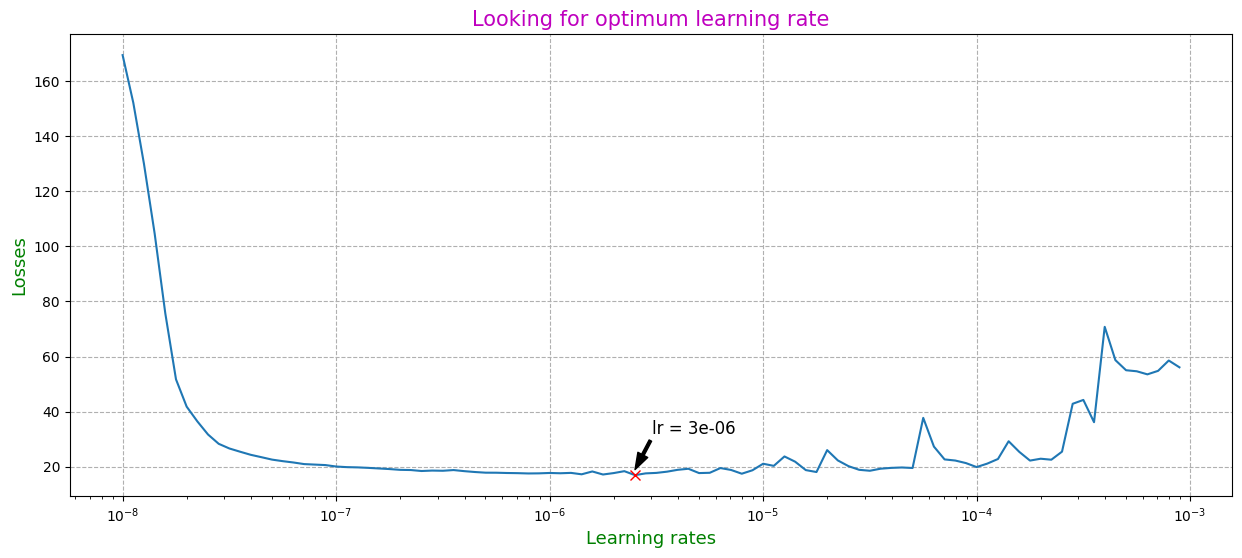

In [24]:
# Plot the output for losses vs LR
fig = plt.figure(figsize = (15,6))
plt.semilogx(lrs, history.history['loss'])
plt.grid(True, ls='--')
plt.plot(opt_lr, min_loss, color='r', marker='x', markersize=7)
plt.title(f"Looking for optimum learning rate", color='m', fontsize=15)
plt.ylabel("Losses", fontsize=13, color='g')
plt.xlabel("Learning rates", fontsize= 13, color='g')
plt.annotate(f"lr = {x}", (opt_lr, min_loss+2), (opt_lr+0.05e-5, min_loss+15), arrowprops = dict(facecolor = 'k', width=2, headwidth=8), fontsize=12)
plt.show()

# training the model with optimum learning rate

In [25]:
# using the same steps to build the model but now with the optimal learning rate to train it
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=132, kernel_size=4, padding = 'causal', activation='softmax', input_shape=[None, 1]),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(132, return_sequences=False),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=opt_lr, momentum=momentum_sgd)

model.compile(loss=tf.keras.losses.Huber(delta),
             optimizer=optimizer,
             metrics=['mae'])

history=model.fit(train_set, epochs=train_epochs)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 64.5020 - mae: 65.0008
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 46.6384 - mae: 47.1361
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 40.3332 - mae: 40.8296
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 37.2359 - mae: 37.7342
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 34.4103 - mae: 34.9073
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.7923 - mae: 32.2895
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.8229 - mae: 30.3201
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.4459 - mae: 28.9416
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.3148 - mae: 26.8099
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.0810 - mae: 28.5774
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 25.6996 - mae: 26.1954
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 25.2780 - mae: 25.7728
E

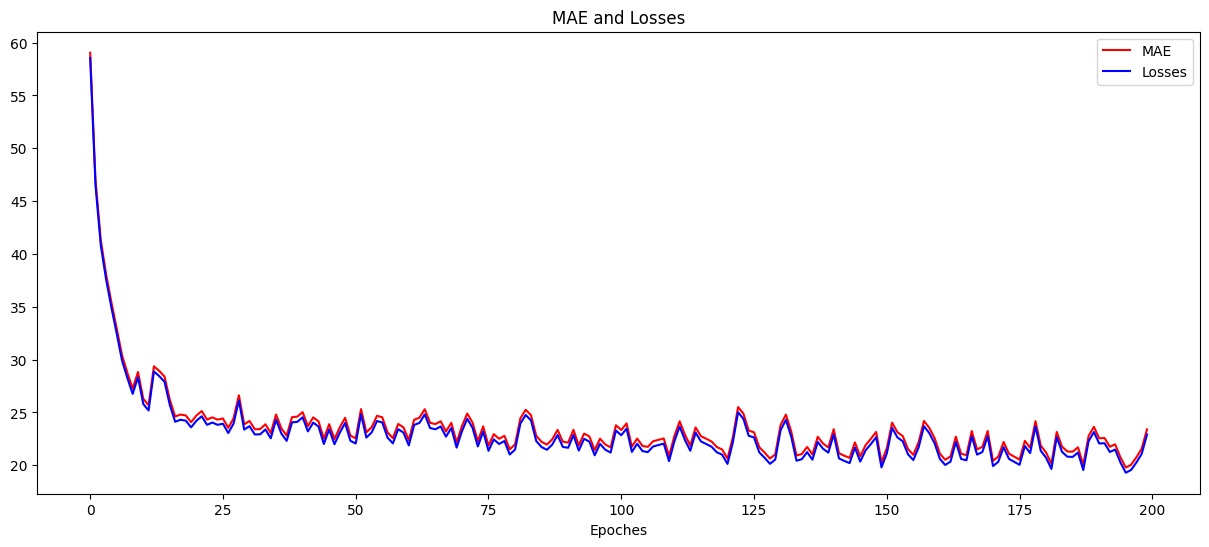

In [26]:
# Fetch the MAE and Huber loss from the history
mae = history.history['mae']
loss = history.history['loss']

#plot MAE and Huber Loss
fig = plt.figure(figsize=(15,6))
plt.plot(mae, 'r')
plt.plot(loss, 'b')
plt.title("MAE and Losses")
plt.xlabel("Epoches")
plt.legend(["MAE", "Losses"])
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


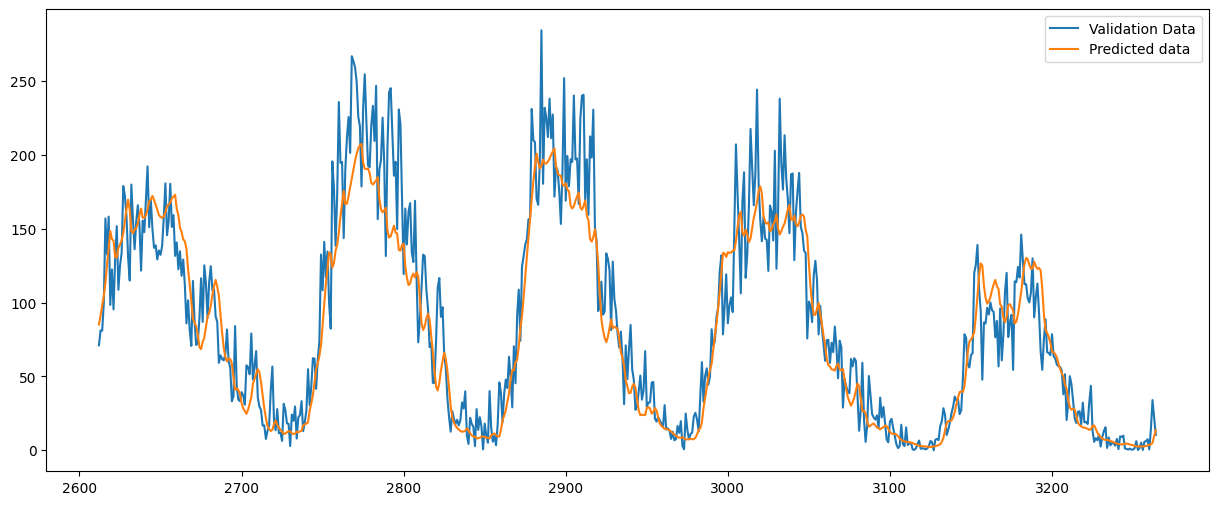

In [27]:
#Call the model_forcasting function and display the plots of validation and prediction 
rnn_forcast = model_forcast(model, series[:, np.newaxis], window_size)
rnn_forcast = rnn_forcast[split_time - window_size:-1, 0]

#plots
plt.figure(figsize = (15,6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forcast)
plt.title("")
plt.legend(['Validation Data', 'Predicted data'])
plt.show()

In [28]:
#Validation MAE
val_mae = tf.keras.metrics.mae(x_valid, rnn_forcast).numpy()
print(f"MAE on the validation data :- {val_mae}")

MAE on the validation data :- 19.3557071685791
